# 2. Optimisation (dealing with adaptive attacks)
use the pre-computed prediction for each sample ("sample_features.pkl") in optimisation. The pre-computed data is required.

In [1]:
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange

sample_features = pd.read_pickle('sample_features.pkl')

my_systems = {
    'FaceNet':64.01,
    'r50':76.63,
    'EfficientNet':76.95,
    'ReXNet':76.29,
    'AttentionNet':74,
    'RepVGG':76.61,
    'GhostNet':77.78,
    'TF-NAS':75.86,
    'LightCNN':77.52
}

get_angle = lambda a, b: np.rad2deg(np.arccos((np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b) + 1e-7))))


In [2]:
sample_features = sample_features[~sample_features.index.duplicated(keep='first')]

In [17]:
P_ = {}

for k, v in my_systems.items():
    
    P_[k] = {}
    
    for m1, m1_, m2, same in pd.read_csv('test_suite/glasses_7.csv').values:


        i1 = sample_features[k][m1]
        i2 = sample_features[k][m2]
        i1_ = sample_features[k][m1_]

        y_pred = get_angle(i1, i2) < v
        y_pred_ = get_angle(i1_, i2) < v

        P_[k][m1, m1_, m2, same] = (y_pred == y_pred_)

df = pd.DataFrame(P_)

In [18]:
len(sample_features)

143732

In [19]:
from scipy import stats
import matplotlib.pyplot as plt

def show_crr(silver, bronze, *groups):

    ma = ['<', 'P', 'd']
    cl = ['#ff0000', '#0000ff', '#00ff00', '#000000']
    
    fig=plt.figure(figsize=(4,4), dpi= 100, facecolor='w', edgecolor='k')

    for i, g in enumerate(groups):
        plt.plot(g, silver[g], color=cl[i], marker=ma[i], ms=9, label=f"Group {i} silver")
        plt.plot(g, bronze[g], '-.', color=cl[i], marker=ma[i], ms=9, label=f"Group {i}: crr {stats.pearsonr(bronze[g], silver[g])[0]:.2f}")

    plt.xlabel("System ID")
    plt.ylabel("True Positive Rate")
    # plt.title(f"")
    plt.legend()
    plt.show()
    return stats.pearsonr(bronze[groups[0]], silver[groups[0]])[0]


In [20]:
known_robustness = np.array([3764.00, 2354.00, 2619.00, 2433.00, 1635.00, 2373.00, 2592.00, 2207.00, 3600.00])
known_robustness = (known_robustness - known_robustness.min())/ (known_robustness.max() - known_robustness.min())
known_robustness

array([1.        , 0.33771724, 0.46218882, 0.37482386, 0.        ,
       0.34664162, 0.44950681, 0.26867074, 0.92296853])

In [21]:
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize

from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling

from pymoo.core.population import Population



def obj_func(inputs, x):
    return - np.array(list(map(lambda b: obj_func_single(inputs, b), x)))

class MyProblem(Problem):

    def __init__(self, inputs):
        self.inputs = inputs
        super().__init__(n_var=self.inputs.shape[0], n_obj=1, n_constr=0, xl=0, xu=1, type_var=int)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = obj_func(self.inputs, x)
        # print(x.sum(1).min() - 1200)
        # out["G"] = x.sum(1) - 1200

In [22]:
indices = np.array([0, 2, 3, 4, 5, 6, 7, 8])
tuning = np.array([0, 2, 3, 4, 5])
testing = np.array([x for x in indices if x not in tuning])


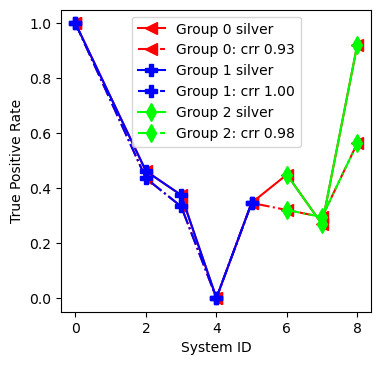

[1.    3.218 0.436 0.333 0.    0.346 0.321 0.295 0.564]
262


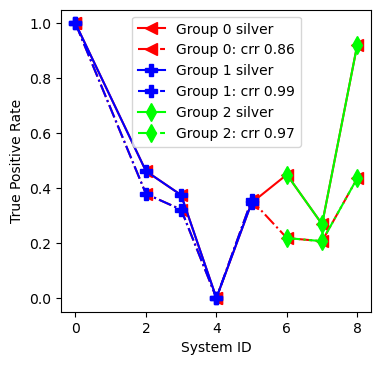

[1.    2.966 0.379 0.322 0.    0.356 0.218 0.207 0.437]
278


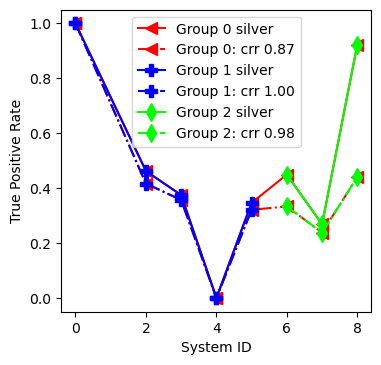

[1.    3.107 0.417 0.357 0.    0.321 0.333 0.238 0.44 ]
279


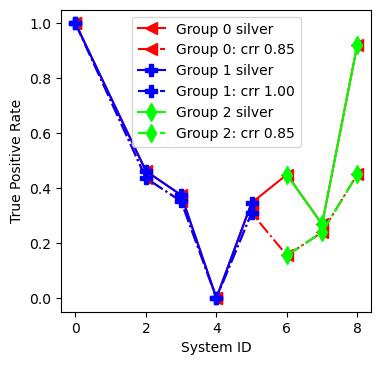

[1.    3.437 0.437 0.352 0.    0.31  0.155 0.239 0.451]
263


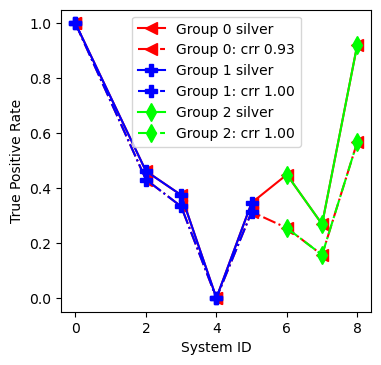

[1.    4.451 0.431 0.333 0.    0.314 0.255 0.157 0.569]
250


In [86]:
def obj_func_single(inputs, variables):
    bronze = np.nanmean(inputs[variables.astype(bool)], 0)
    return stats.pearsonr(bronze[tuning], known_robustness[tuning])[0] + bronze[tuning].mean() * 1e-0 + bronze[tuning].std() * 1e-0 - variables.sum() / len(variables) #- max(1200, len(variables))  * 1e-2

algorithm = GA(
    pop_size=280,
    sampling=BinaryRandomSampling(),
    crossover=TwoPointCrossover(),
    mutation=BitflipMutation(),
    eliminate_duplicates=True)


releases = []

for r in range(5):
    df_ = - df.iloc[r::5,]
    res = minimize(
        MyProblem(df_.values.astype(int)),
        algorithm,
        ('n_gen', 100),
        verbose=False)

    predicted_robustness = df_.values[res.X.astype(bool)].mean(0)
    predicted_robustness = (predicted_robustness - predicted_robustness[indices].min())/ (predicted_robustness[indices].max() - predicted_robustness[indices].min())
    crr = show_crr(known_robustness, predicted_robustness, indices, tuning, testing)
    print(np.round(predicted_robustness, 3))
    print(res.X.sum())
    releases.append(list(df_[res.X].index))


In [87]:
import torch
import torchvision

class GeneralDataset(torch.utils.data.Dataset):
    def __init__(self, samples):
        super(GeneralDataset, self).__init__()
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        sample = {'m1': (torchvision.io.read_image('../lfw/' + self.samples[index][0], mode=torchvision.io.ImageReadMode.RGB) - 127.5) / 128.0,
               'm1_': (torchvision.io.read_image('../lfw/' + self.samples[index][1], mode=torchvision.io.ImageReadMode.RGB) - 127.5) / 128.0,
               'm2': (torchvision.io.read_image('../lfw/' + self.samples[index][2], mode=torchvision.io.ImageReadMode.RGB) - 127.5) / 128.0,
               'same': self.samples[index][3]
              }
        return sample

In [120]:
public_set = GeneralDataset(releases[0])

private_set = GeneralDataset(releases[4])
# adaptive_set = GeneralDataset(list(set(releases[0]) - set(releases[1])))


another_loader = torch.utils.data.DataLoader(private_set, batch_size = 32, shuffle = False)
adaptive_loader = torch.utils.data.DataLoader(public_set, batch_size = 32, shuffle = False)


In [121]:
from blackbox_adversarial.image2feature import get_model

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import random
random.seed(314)

m_name = random.choice(list(my_systems.keys()))
model = get_model(m_name)['m'].to(device)


backbone param:
{'input_ch': 16, 'final_ch': 180, 'width_mult': 1.0, 'depth_mult': 1.0, 'use_se': 0, 'se_ratio': 12, 'out_h': 7, 'out_w': 7, 'feat_dim': 512, 'dropout_ratio': 0.2}


In [122]:
lr = 0.0001
my_optimizer = torch.optim.Adam(model.parameters(), 
                           lr=lr)

In [123]:
import torch.nn.functional as F
from scipy.signal import savgol_filter



public_robustnesses = []
private_robustnesses = []
for epoch in range(10):
    model.train()
    public_robustness = []
    private_robustness = []    
    for batch in tqdm(adaptive_loader):
        
        m1 = batch['m1'].to(device)
        m2 = batch['m2'].to(device)
        m1_ = batch['m1_'].to(device)
        same = batch['same'].to(device)

        f1 = model(m1)
        f2 = model(m2)
        f1_ = model(m1_)

        loss = F.mse_loss(F.cosine_similarity(f1, f2), F.cosine_similarity(f1_, f2))
        
        y_pred = np.rad2deg(np.arccos(F.cosine_similarity(f1, f2).detach().cpu().numpy())) < my_systems[m_name]
        y_pred_ = np.rad2deg(np.arccos(F.cosine_similarity(f1_, f2).detach().cpu().numpy())) < my_systems[m_name]
        robustness = y_pred == y_pred_

        public_robustness.append(robustness.mean())
        
        my_optimizer.zero_grad()
        loss.backward()
        my_optimizer.step()    
        
    public_robustnesses.append(np.mean(public_robustness))
        
    model.eval()

    with torch.no_grad():

        for batch in tqdm(another_loader):
            m1 = batch['m1'].to(device)
            m2 = batch['m2'].to(device)
            m1_ = batch['m1_'].to(device)

            f1 = model(m1)
            f2 = model(m2)
            f1_ = model(m1_)
            
            y_pred = np.rad2deg(np.arccos(F.cosine_similarity(f1, f2).cpu().numpy())) < my_systems[m_name]
            y_pred_ = np.rad2deg(np.arccos(F.cosine_similarity(f1_, f2).cpu().numpy())) < my_systems[m_name]
            robustness = y_pred == y_pred_
            
            private_robustness.append(robustness.mean())
    

    private_robustnesses.append(np.mean(private_robustness))

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [124]:
pd.DataFrame({
    'Public':{'Before overfitting':public_robustnesses[0], 'After overfitting':public_robustnesses[-1]},
    'Pribvate':{'Before overfitting':private_robustnesses[0], 'After overfitting':private_robustnesses[-1]}
})



,Public,Pribvate
Before overfitting,0.848380,0.937500
After overfitting,0.996528,0.971755
